In [1]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.metrics import ndcg_score, accuracy_score
import random

import chgk_api as cha

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [2]:
# настройки

# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

# процентили, на которые мы разделили выборрку турнира по стартовому рейтингу
first_percentile = 0.1
second_percentile = 0.5

# количество команд, которые участвуют в построении метрики
k_opt = 200

# тестовый турнир для проверки работы функций
# гостинный двор-2024, калуга
# tourn_id = 10707
# Островок Бесконечности: октябрь
# tourn_id = 10396
start_date = '2024-12-01'
finish_date = '2024-12-02'

In [3]:
def make_metrics(df, segment_col, target_col, pred_col, k=5, is_size=True, suffix='', param_value='', param_col='', tourn_id=0):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    work_df = df.copy()
    work_df.sort_values(by=[target_col, segment_col], ascending=[True, True])
    grouped = work_df.groupby(segment_col)
    ndcg_lst = []
    acc_lst = []

    for name, group in grouped:
        group = group.sort_values(by=target_col)
        y_true = np.array([group[target_col]])
        y_pred = np.array([group[pred_col]])
        
        ndcg = ndcg_score(y_true, y_pred, k=k)
        ndcg_lst.append({segment_col: name, 'ndcg': ndcg})

        # accuracy_score не работает с float, 
        # поэтому выводим дробную часть в виде числа
        # y_true = (y_true * 10).astype('int')
        # y_pred = (y_pred * 10).astype('int')
        # поэтому округляем вниз, делённое место считаем целевым
        y_true = np.floor(y_true).astype('int')
        y_pred = np.floor(y_pred).astype('int')

        acc = accuracy_score(y_true[0], y_pred[0])
        acc_lst.append({segment_col: name, 'accuracy': acc})

    metrics_df = work_df.groupby(segment_col).agg(
                                                    size = ('team_id', 'nunique'),
                                                    ).reset_index()
    ndcg_df = pd.DataFrame(ndcg_lst)
    acc_df = pd.DataFrame(acc_lst)

    metrics_df = metrics_df.merge(ndcg_df, 'left', on=segment_col)
    metrics_df = metrics_df.merge(acc_df, 'left', on=segment_col)

    if is_size == False:
        del metrics_df['size']
        metrics_df.columns = ['segment', 'ndcg'+suffix, 'accuracy'+suffix]
    else:
        metrics_df.columns = ['segment', 'size', 'ndcg'+suffix, 'accuracy'+suffix]
    
    metrics_df['tourn_id'] = tourn_id
    metrics_df[param_col] = param_value

    return metrics_df

def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df


def get_tours_distr(json_data):
    """
    Собираем структуру турнира по json из API
    """
    size = len(json_data)
    qv_lst = []
    tour_lst = []
    max_qv = 0
    for t in range(1, size+1):
        rr = range(max_qv+1, max_qv+json_data[str(t)]+1)
        max_qv = rr[-1]
        for q in rr:
            qv_lst.append(q)
            tour_lst.append(t)
    
    df = pd.DataFrame(qv_lst, columns=['question_num'])
    df['tour_id'] = tour_lst
    return df


def get_tours_res_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза по сумме мест в турах
    """
    tours_distr = get_tours_distr(df['questionQty'].values[0])
    df = df.merge(tours_distr, 'left', on='question_num')

    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', 'tour_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    gr_df['tour_place'] = gr_df.groupby(['tourn_id', 'tour_id'])['current_res'].rank(method='average', ascending=False)
    
    tr_df = gr_df.groupby(['tourn_id', 'team_id', segment_col]).agg(
        tour_placses = ('tour_place', 'sum'),
    ).reset_index()
    tr_df['tour_forecast'] = tr_df.groupby(['tourn_id'])['tour_placses'].rank(method='average', ascending=False)

    totals_df = get_target(df)
    tr_df = tr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    tr_df = tr_df.sort_values(by='target_question', ascending=False)

    return tr_df

def get_data(tourn_id):
    """
    Функция для сборки датасета и проставлении необхоимых полей
    """
    # получаем данные по API
    tourn_df, question_df, players_df = cha.get_tourn_result(tourn_id)
    qv_stat = cha.tourn_stat(question_df)

    # назначаем командам сегмент по стартовой крутости
    tourn_df['segment'] =np.where(
        (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.1)), '1.top_10%',
        np.where(
                    (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.5)) &
                    (tourn_df['predictedPosition'] > tourn_df['predictedPosition'].quantile(.1)), '2.top_50%', '3.bottom_50%'
                )
                                )
    

    # собираем нужный датасет
    work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position', 'segment']], 'left', on=['tourn_id', 'team_id'])
    work_df['qv_result'] = work_df['qv_result'].astype('int')

    work_df = work_df.sort_values(by=['tourn_id', 'predictedPosition', 'segment', 'team_id', 'question_num'])

    return tourn_df, question_df, players_df, work_df

In [4]:
# проверяем работу функций
# список турниров за определённую дату, первая страница пагинации
tourn_lst_df = cha.get_tourn_list(start_date, finish_date, 1)
tourn_lst_df.sample(3)

200


,tourn_id,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
2,11448,"Фестиваль интеллектуальных игр ""Memory Fest. SPB""",Обычный,59,0.0,True,3.69791,"{'1': 12, '2': 12, '3': 12, '4': 12}"
1,11416,"Фестиваль интеллектуальных игр ""Memory Fest""",Обычный,59,0.0,True,3.69327,"{'1': 12, '2': 12, '3': 12, '4': 12}"
0,11350,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"


In [5]:
# собранный датассет по одному турниру
tourn_id = tourn_lst_df['tourn_id'].values[0]
tourn_df, question_df, players_df, work_df = get_data(tourn_id)
work_df = work_df.merge(tourn_lst_df, on='tourn_id')
work_df.sample(3)

200


,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
247,11350,92787,52,40,1,5,5.5,2.top_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"
1585,11350,98910,52,26,0,31,31.0,3.bottom_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"
417,11350,102925,52,2,0,9,13.0,2.top_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"


In [6]:
# прогноз по занятому месту к 12 вопросу по сегменту стартовой крутости
grtf = get_current_taken_forecast(work_df, 12, 'segment')
grtf.sample(3)

,tourn_id,team_id,segment,current_res,target_question,target,current_place
29,11350,102925,2.top_50%,7,26,13.0,12.5
12,11350,88469,3.bottom_50%,7,21,19.0,12.5
18,11350,93765,2.top_50%,6,26,13.0,18.5


In [7]:
# метрики точности прогноза по сегментам
make_metrics(
                grtf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                k=k_opt,
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,1.top_10%,4,0.896666,0.5,11350,
1,2.top_50%,12,0.955135,0.0,11350,
2,3.bottom_50%,15,0.951863,0.0,11350,


In [8]:
# по всей выборке тоже можно сделать
make_metrics(
                grtf, 
                segment_col='tourn_id', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,11350,31,0.870292,0.064516,11350,


In [9]:
# прогноз по рейтингу взятых вопросов к 12 вопросу по сегменту стартовой крутости
gcqrf = get_current_qv_rating_forecast(work_df, 12, 'segment')
gcqrf.sample(3)

,tourn_id,team_id,segment,current_rating,rating_place,target_question,target
14,11350,89357,3.bottom_50%,64,16.5,19,21.5
26,11350,100148,3.bottom_50%,102,3.5,29,10.0
7,11350,83822,2.top_50%,100,6.0,25,15.5


In [10]:
# метрики точности прогноза по сегментам
make_metrics(
                gcqrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='rating_place', 
                is_size=True, 
                suffix='_qv_rating_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_qv_rating_forecast,accuracy_qv_rating_forecast,tourn_id,
0,1.top_10%,4,0.896666,0.0,11350,
1,2.top_50%,12,0.831750,0.0,11350,
2,3.bottom_50%,15,0.848887,0.0,11350,


In [11]:
# прогноз по сумме мест в турах к 12 вопросу по сегменту стартовой крутости
gtrf = get_tours_res_forecast(work_df, 12, 'segment')
gtrf.sample(3)

,tourn_id,team_id,segment,tour_placses,tour_forecast,target_question,target
7,11350,83822,2.top_50%,7.5,24.5,25,15.5
22,11350,99885,1.top_10%,7.5,24.5,33,2.5
9,11350,86874,3.bottom_50%,29.5,2.5,14,25.5


In [12]:
# метрики точности прогноза по сегментам
make_metrics(
                gtrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='tour_forecast', 
                is_size=True, 
                suffix='_tours_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_tours_forecast,accuracy_tours_forecast,tourn_id,
0,1.top_10%,4,0.806064,0.000000,11350,
1,2.top_50%,12,0.444053,0.166667,11350,
2,3.bottom_50%,15,0.535922,0.133333,11350,


In [13]:
# прогноз по стартовому рейтингу
trdf = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,4,0.863453,0.500000,11350,
1,2.top_50%,12,0.919158,0.416667,11350,
2,3.bottom_50%,15,0.940157,0.066667,11350,


In [14]:
# прогноз по случайной тасовке команд
places = list(range(1, len(trdf)+1))
random.shuffle(places)
trdf['random'] = places
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,4,0.758369,0.000000,11350,
1,2.top_50%,12,0.815292,0.166667,11350,
2,3.bottom_50%,15,0.846612,0.000000,11350,


In [16]:
# а теперь проход по всем вопроса турнира
num_of_questions = work_df['numqv'].values[0]
num_of_teams = work_df['team_id'].nunique()

questions = pd.DataFrame(range(1, num_of_questions+1), columns=['question_num'])
questions['tourn_id'] = tourn_id

# прогноз по стартовому рейтингу
teams_smpl = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
start_df_forec = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                k=k_opt,
                suffix='_start_rating_forecast', 
                tourn_id=tourn_id)

res_df = questions.merge(start_df_forec, 'left', on='tourn_id')

# прогноз по случайной тасовке команд
places= list(range(1, len(teams_smpl)+1))
random.shuffle(places)
teams_smpl['random'] = places
shuffle_forecast = make_metrics(
                teams_smpl, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=False, 
                k=k_opt,
                suffix='_shuffle_forecast', 
                tourn_id=tourn_id)


res_df = res_df.merge(shuffle_forecast, 'left', on=['segment'], suffixes=('', '_random'))

qv_forecast_metric_df = pd.DataFrame()
rating_forecast_metric_df = pd.DataFrame()
tours_sum_forecast_metric_df = pd.DataFrame()
for i in range(1, num_of_questions+1):
    qv_forecast_df = get_current_taken_forecast(work_df, i, 'segment')
    rating_forecast_df = get_current_qv_rating_forecast(work_df, i, 'segment')
    tours_sum_forecast_df = get_tours_res_forecast(work_df, i, 'segment')

    qv_forecast_metric_df_b = make_metrics(
                    qv_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='current_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_current_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)
    
    rating_forecast_metric_df_b = make_metrics(
                    rating_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='rating_place', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_qv_rating_place_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)
    
    tours_sum_forecast_metric_df_b = make_metrics(
                    tours_sum_forecast_df, 
                    segment_col='segment', 
                    target_col='target', 
                    pred_col='tour_forecast', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_tours_sum_forecast', 
                    param_value=i,
                    param_col='question_num', 
                    tourn_id=tourn_id)

    qv_forecast_metric_df = pd.concat([qv_forecast_metric_df, qv_forecast_metric_df_b])
    rating_forecast_metric_df = pd.concat([rating_forecast_metric_df, rating_forecast_metric_df_b])
    tours_sum_forecast_metric_df = pd.concat([tours_sum_forecast_metric_df, tours_sum_forecast_metric_df_b])

res_df = res_df.merge(qv_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
res_df = res_df.merge(rating_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
res_df = res_df.merge(tours_sum_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])

In [17]:
len(res_df)

156

In [19]:
res_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast,ndcg_tours_sum_forecast,accuracy_tours_sum_forecast
86,29,11350,3.bottom_50%,15,0.983800,0.066667,,0.943042,0.066667,11350,,0.992917,0.066667,0.989657,0.133333,0.815328,0.066667
118,40,11350,2.top_50%,12,0.977567,0.416667,,0.857702,0.000000,11350,,0.991687,0.000000,0.992530,0.166667,0.696377,0.000000
130,44,11350,2.top_50%,12,0.977567,0.416667,,0.857702,0.000000,11350,,0.986925,0.250000,0.992502,0.166667,0.704508,0.000000


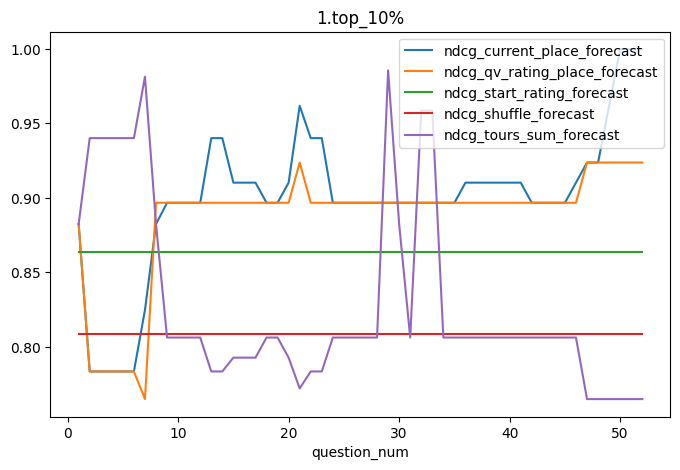

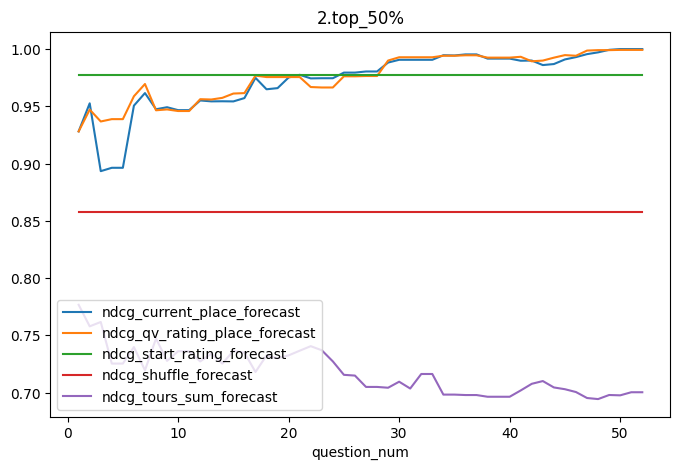

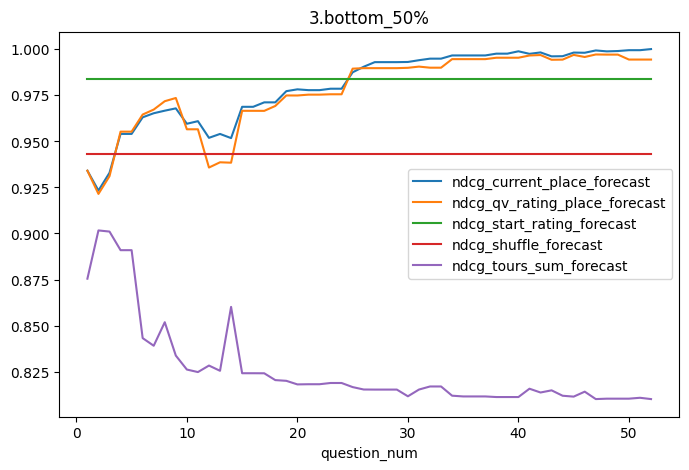

In [21]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', 
                                                                    'ndcg_tours_sum_forecast'
                                                                    ]].plot(title=segment)

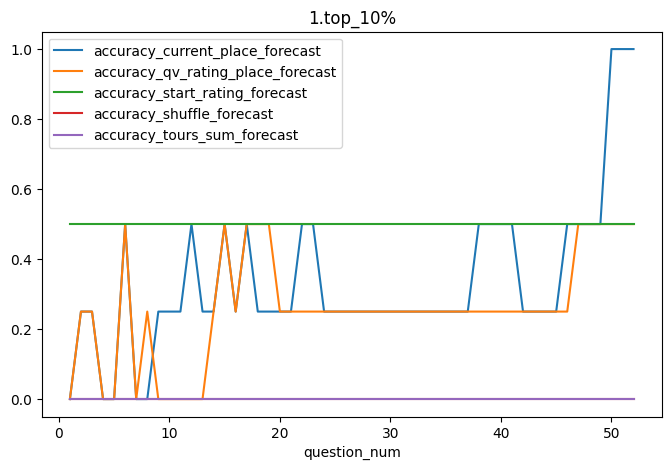

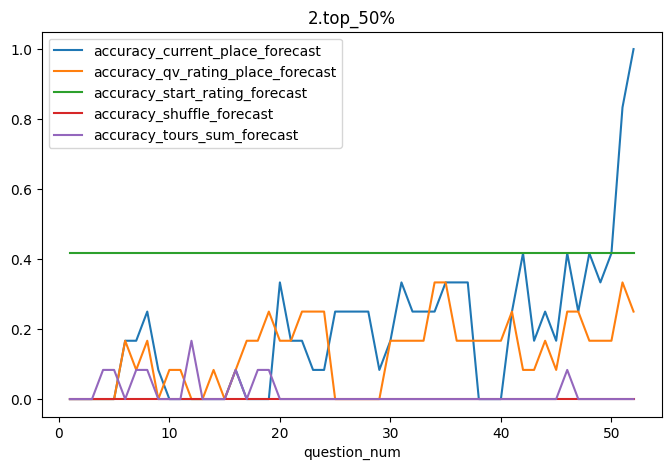

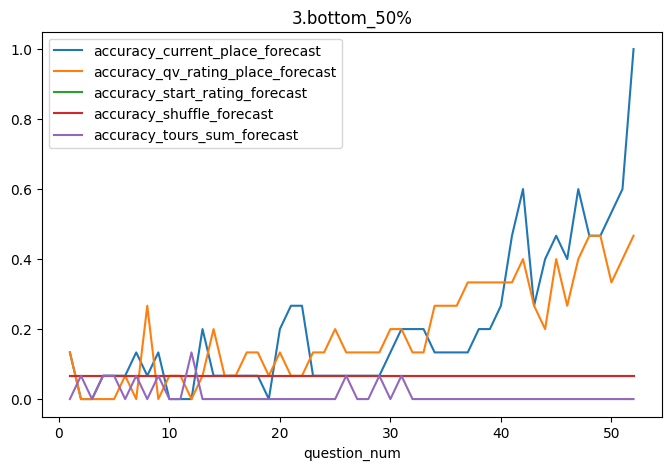

In [22]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'accuracy_current_place_forecast', 
                                                                    'accuracy_qv_rating_place_forecast',
                                                                    'accuracy_start_rating_forecast', 
                                                                    'accuracy_shuffle_forecast', 
                                                                    'accuracy_tours_sum_forecast'
                                                                    ]].plot(title=segment)

In [ ]:
# в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
res_df[res_df['question_num'] == num_of_questions - test_distnce].set_index('segment')[[                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', ]].T

In [33]:
# TO DO
# комментарии
# признак равенства очков на момент перестрелки
# обратная перестрелка (без микроматчей никак)
# приджойнить метрики к ворку
# добавить две метода к общему резу
# приджойнить параметры турниров к турниру
# стату по турнирам